In [1]:
import stlearn as st
import pandas as pd
import random
from pathlib import Path
import scanpy as sc
from PIL import Image
import numpy as np

In [2]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from typing import Optional, Union
from anndata import AnnData
import os
from stlearn._compat import Literal


def QC_plot(
        adata: AnnData,
        library_id: str = None,
        name: str = None,
        data_alpha: float = 0.8,
        tissue_alpha: float = 1.0,
        cmap: str = "Spectral_r",
        spot_size: tuple = (5, 40),
        show_color_bar: bool = True,
        show_size_legend: bool = True,
        show_axis: bool = False,
        dpi: int = 192,
        output: str = None,
) -> Optional[AnnData]:
    """\
        QC plot for sptial transcriptomics data.

        Parameters
        ----------
        adata
            Annotated data matrix.
        library_id
            Library id stored in AnnData.
        data_alpha
            Opacity of the spot.
        tissue_alpha
            Opacity of the tissue.
        cmap
            Color map to use.
        spot_size
            Size of the spot (min, max).
        show_color_bar
            Show color bar or not.
        show_axis
            Show axis or not.
        show_size_legend
            Show size legend or not.
        dpi
            Set dpi as the resolution for the plot.
        name
            Name of the output figure file.
        output
            Save the figure as file or not.
        copy
            Return a copy instead of writing to adata.
        Returns
        -------
        Nothing
        """
    from sklearn.preprocessing import MinMaxScaler
    reads_per_spot = adata.to_df().sum(axis=1)
    scaler = MinMaxScaler(feature_range=spot_size)
    reads_per_spot_size = scaler.fit_transform(
        reads_per_spot.to_numpy().reshape(-1, 1))
    genes_per_spot = adata.to_df().astype(bool).sum(axis=1)

    plt.rcParams['figure.dpi'] = dpi

    # Option for turning off showing figure
    plt.ioff()

    # Initialize matplotlib
    fig, a = plt.subplots()
    
    x_min, x_max = adata.obs["imagecol"].min(), adata.obs["imagecol"].max()
    y_min, y_max = adata.obs["imagerow"].min(), adata.obs["imagerow"].max()
    add_x = (x_max - x_min)//20
    add_y = (y_max - y_min)//20
    
    plt.xlim([x_min - add_x, x_max + add_x])
    plt.ylim([y_max + add_y, y_min - add_y])

    vmin = min(genes_per_spot)
    vmax = max(genes_per_spot)
    # Plot scatter plot based on pixel of spots
    plot = a.scatter(adata.obs["imagecol"], adata.obs["imagerow"], edgecolor="none", alpha=data_alpha,
                     s=reads_per_spot_size, marker="o",
                     vmin=vmin, vmax=vmax, cmap=plt.get_cmap(cmap), c=genes_per_spot)

    if show_color_bar:
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        axins = inset_axes(a,
                   width="100%", 
                   height="100%",
                   loc='upper left',
                   bbox_to_anchor=(1.0, 0.73, 0.05, 0.35),
                   bbox_transform=a.transAxes,
                   borderpad=4.3,
                   )
        cb = plt.colorbar(plot, cax=axins)
#         cb = plt.colorbar(plot, cax=fig.add_axes([0.85, 0.5, 0.05, 0.35]), cmap=cmap)
#         from mpl_toolkits.axes_grid1 import make_axes_locatable
#         divider = make_axes_locatable(plt.gca())
#         cax = divider.append_axes("right", "5%", pad="3%")
#         cb = plt.colorbar(plot, cax=cax)
        cb.ax.set_xlabel('Number of Genes', fontsize=10)
        cb.ax.xaxis.set_label_coords(0.98, 1.20)
        cb.outline.set_visible(False)

    if show_size_legend:
        size_min, size_max = spot_size
        markers = [size_min, size_min + 1 / 3 * (size_max - size_min),
                   size_min + 2 / 3 * (size_max - size_min), size_max]
        legend_markers = [plt.scatter([], [], s=i, c="grey") for i in markers]
        labels = [str(int(scaler.inverse_transform(np.array(i).reshape(1, 1))))
                  for i in markers]
        a.legend(handles=legend_markers, labels=labels, loc='lower left', bbox_to_anchor=(1, 0.05),
                   scatterpoints=1, frameon=False, title="Number of Reads")
#         a.legend(handles=legend_markers, loc='center left', bbox_to_anchor=(1, 0.5), prop=dict(size=8),
#                  title="Number of Reads"))

    if not show_axis:
        a.axis('off')
    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"]["use_quality"]]
    # Overlay the tissue image
    a.imshow(image, alpha=tissue_alpha, zorder=-1, )

    # fig.tight_layout()
    if output is not None:
        fig.savefig(output + "/" + name + ".png", dpi=dpi,
                    bbox_inches='tight', pad_inches=0)

    plt.show()


def add_mask(
    adata: AnnData,
    imgpath: Union[Path, str],
    copy: bool = False,
    key: str = "mask"
) -> Optional[AnnData]:

    """\
    Adding image data to the Anndata object

    Parameters
    ----------
    adata
        Annotated data matrix.
    imgpath
        Image path.
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    scale
        Set scale factor.
    quality
        Set quality that convert to stlearn to use. Store in anndata.obs['imagecol' & 'imagerow'].
    visium
        Is this anndata read from Visium platform or not.
    copy
        Return a copy instead of writing to adata.
    Returns
    -------
    Depending on `copy`, returns or updates `adata` with the following fields.
    **tissue_img** : `adata.uns` field
        Array format of image, saving by Pillow package.
    """
    try:
        library_id = list(adata.uns["spatial"].keys())[0]
        quality = adata.uns["spatial"]["use_quality"]
    except:
        raise KeyError(f'''\
        Please read ST data first and try again
        '''
        )
    
    if imgpath is not None and os.path.isfile(imgpath):
        try:
            img = np.asarray(Image.open(imgpath))
            assert img.shape == adata.uns["spatial"][library_id]["images"]["hires"].shape, "\
            size of mask image does not match size of H&E images"
            if "mask_image" not in adata.uns:
                adata.uns["mask_image"] = {}
            if library_id not in adata.uns["mask_image"]:
                adata.uns["mask_image"][library_id] = {}
            if key not in adata.uns:
                adata.uns["mask_image"][library_id][key] = {}
            
            adata.uns["mask_image"][library_id][key][quality] = img
            print("Added tissue mask to the object!")

            return adata if copy else None
        except:
            raise ValueError(f'''\
            {imgpath!r} does not end on a valid extension.
            ''')
    else:
        raise ValueError(f'''\
        {imgpath!r} does not end on a valid extension.
        ''')
    return adata if copy else None

def apply_mask(
    adata: AnnData,
    masks: Optional[list] = "all",
    key: str = "mask_annotation",
    select: str = "black",
    cmap: str = "vega_20_scanpy",
    copy: bool = False
) -> Optional[AnnData]:
    
    from scanpy.plotting import palettes
    if cmap == "vega_10_scanpy":
        cmap = palettes.vega_10_scanpy
    elif cmap == "vega_20_scanpy":
        cmap = palettes.vega_20_scanpy
    elif cmap == "default_102":
        cmap = palettes.default_102
    elif cmap == "default_28":
        cmap = palettes.default_28
    else:
        raise ValueError(
            "We only support vega_10_scanpy, vega_20_scanpy, default_28, default_102")
    
    cmaps = matplotlib.colors.LinearSegmentedColormap.from_list("", cmap)

    cmap_ = plt.cm.get_cmap(cmaps)
    
    try:
        library_id = list(adata.uns["spatial"].keys())[0]
        quality = adata.uns["spatial"]["use_quality"]
    except:
        raise KeyError(f'''\
        Please read ST data first and try again
        ''')
    
    if masks == "all":
        masks = list(adata.uns["mask_image"][library_id].keys())
    else:
        assert isinstance(masks, list)
    
    adata.obs[key] = "unassigned"
    adata.obs[key+"_code"] = -1
    mask_final = np.zeros(adata.uns["spatial"][library_id]["images"]["hires"].shape)
    for i, mask in enumerate(masks):
        try:
            mask_image = adata.uns["mask_image"][library_id][mask][quality]
        except:
            raise KeyError(f'''\
            Please load mask {mask} images first and try again
            ''')

        if select == "black":
            mask_image = np.where(mask_image > 155, 0, 1)
        elif select == "white":
            mask_image = np.where(mask_image > 155, 0, 1)
        else:
            raise ValueError(f'''\
            Only support black and white mask yet.
            ''')
        mask_image_2d = mask_image.mean(axis=2)
        apply_spot_mask = lambda x: [i, mask] if mask_image_2d[int(x["imagerow"]), int(x["imagecol"])] == 1 else [x[key+"_code"], x[key]]
        spot_mask_df = adata.obs.apply(apply_spot_mask, axis=1, result_type="expand")        
        adata.obs[key+"_code"] = spot_mask_df[0]
        adata.obs[key] = spot_mask_df[1]

        c = cmap_(i/19)
        mask_final = mask_final + mask_image * np.array(c[0:3])
    print(f'''Mask annotation for spots added to `adata.obs["{key}"]`''')
    mask_final[mask_final == 0] = 1
    adata.uns[key] = mask_final
    print(f'''Mask annotation for H&E image added to `adata.uns["{key}"]`''')
    return adata if copy else None


def plot_mask(
    adata: AnnData,
    library_id: str = None,
    key: str = "mask_annotation",
    show_spot: bool = True,
    spot_alpha: float = 1.0,
    cmap: str = "vega_20_scanpy",
    tissue_alpha: float = 1.0,
    mask_alpha: float = 0.5,
    spot_size: Union[float, int] = 6.5,
    show_legend: bool = True,
    dpi: int = 180,
    show_axis: bool = False,
    copy: bool = False,
    out_path: str = None
) -> Optional[AnnData]:
    
    from scanpy.plotting import palettes
    if cmap == "vega_10_scanpy":
        cmap = palettes.vega_10_scanpy
    elif cmap == "vega_20_scanpy":
        cmap = palettes.vega_20_scanpy
    elif cmap == "default_102":
        cmap = palettes.default_102
    elif cmap == "default_28":
        cmap = palettes.default_28
    else:
        raise ValueError(
            "We only support vega_10_scanpy, vega_20_scanpy, default_28, default_102")
    
    cmaps = matplotlib.colors.LinearSegmentedColormap.from_list("", cmap)

    cmap_ = plt.cm.get_cmap(cmaps)
    
    plt.rcParams['figure.dpi'] = dpi

    # Option for turning off showing figure
    plt.ioff()

    # Initialize matplotlib
    fig, a = plt.subplots()
    
    x_min, x_max = adata.obs["imagecol"].min(), adata.obs["imagecol"].max()
    y_min, y_max = adata.obs["imagerow"].min(), adata.obs["imagerow"].max()
    add_x = (x_max - x_min)//20
    add_y = (y_max - y_min)//20
    
    plt.xlim([x_min - add_x, x_max + add_x])
    plt.ylim([y_max + add_y, y_min - add_y])

    
    if show_spot:
        for i, cluster in enumerate(adata.obs.groupby(key)): 
            if cluster[1][key+"_code"][0] == -1:
                # Plot scatter plot based on pixel of spots
                _ = a.scatter(cluster[1]["imagecol"], cluster[1]["imagerow"], edgecolor="none", alpha=spot_alpha,
                          s=spot_size, marker="o", c=[(1.0,1.0,1.0,1.0)])
            else:
                # Plot scatter plot based on pixel of spots
                _ = a.scatter(cluster[1]["imagecol"], cluster[1]["imagerow"], edgecolor="none", alpha=spot_alpha,
                          s=spot_size, marker="o", c=[cmap_(int(cluster[1][key+"_code"][0])/19)])
            
    if show_legend:
        from matplotlib.patches import Patch
        legend_elements=[]
        for index, row in adata.obs.groupby(key).first().reset_index().iterrows():
            if row[key+"_code"] == -1:
                legend_elements.append(Patch(color=(1.0,1.0,1.0,1.0), label=row[key]))
            else:
                legend_elements.append(Patch(color=cmap_(int(row[key+"_code"]) / 19), label=row[key]))

        a.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), prop=dict(size=8))
    

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]
    
    image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"]["use_quality"]]

    if not show_axis:
        a.axis('off')
    # Overlay the tissue image
    a.imshow(image, alpha=tissue_alpha, zorder=-1,)
    a.imshow(adata.uns[key], alpha=mask_alpha, zorder=-1,)
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path)
    else:
        plt.show()
    
        
"""Reading and Writing
"""
from pathlib import Path, PurePath
from typing import Optional, Union
from anndata import AnnData
import numpy as np
from PIL import Image
import pandas as pd
import stlearn
import scanpy
import scipy

def Read10X(
    path: Union[str, Path],
    genome: Optional[str] = None,
    count_file: str = "filtered_feature_bc_matrix.h5",
    library_id: str = None,
    load_images: Optional[bool] = True,
    quality: str = "hires"
    ) -> AnnData:
    
    """\
    Read Visium data from 10X (wrap read_visium from scanpy)

    In addition to reading regular 10x output,
    this looks for the `spatial` folder and loads images,
    coordinates and scale factors.
    Based on the `Space Ranger output docs`_.

    .. _Space Ranger output docs: https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview

    Parameters
    ----------
    path
        Path to directory for visium datafiles.
    genome
        Filter expression to genes within this genome.
    count_file
        Which file in the passed directory to use as the count file. Typically would be one of:
        'filtered_feature_bc_matrix.h5' or 'raw_feature_bc_matrix.h5'.
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    load_images
        Load image or not.
    quality
        Set quality that convert to stlearn to use. Store in anndata.obs['imagecol' & 'imagerow']


    Returns
    -------
    Annotated data matrix, where observations/cells are named by their
    barcode and variables/genes by gene name. Stores the following information:
    :attr:`~anndata.AnnData.X`
        The data matrix is stored
    :attr:`~anndata.AnnData.obs_names`
        Cell names
    :attr:`~anndata.AnnData.var_names`
        Gene names
    :attr:`~anndata.AnnData.var`\\ `['gene_ids']`
        Gene IDs
    :attr:`~anndata.AnnData.var`\\ `['feature_types']`
        Feature types
    :attr:`~anndata.AnnData.uns`\\ `['spatial']`
        Dict of spaceranger output files with 'library_id' as key
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['images']`
        Dict of images (`'hires'` and `'lowres'`)
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['scalefactors']`
        Scale factors for the spots
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['metadata']`
        Files metadata: 'chemistry_description', 'software_version'
    :attr:`~anndata.AnnData.obsm`\\ `['spatial']`
        Spatial spot coordinates, usable as `basis` by :func:`~scanpy.pl.embedding`.
    """
    
    from scanpy import read_visium
    adata = read_visium(path, genome=None,
     count_file=count_file,
      library_id=library_id,
       load_images=True)
    adata.var_names_make_unique()

    adata.obs['sum_counts'] = np.array(adata.X.sum(axis=1))

    
    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]
        
    scale = adata.uns["spatial"][library_id]["scalefactors"]["tissue_"+quality+"_scalef"]
    image_coor = adata.obsm["spatial"]*scale

    adata.obs["imagecol"] = image_coor[:,0]
    adata.obs["imagerow"] = image_coor[:,1]
    adata.uns["spatial"]["use_quality"] = quality

    return adata


def ReadOldST(
    count_matrix_file: Union[str, Path] = None,
    spatial_file: Union[str, Path] = None,
    image_file: Union[str, Path] = None,
    library_id: str = "OldST",
    scale: float = 1.0,
    quality: str = "hires"
    ) -> AnnData:

    """\
    Read Old Spatial Transcriptomics data

    Parameters
    ----------
    count_matrix_file
        Path to count matrix file.
    spatial_file
        Path to spatial location file.
    image_file
        Path to the tissue image file
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    scale
        Set scale factor.
    quality
        Set quality that convert to stlearn to use. Store in anndata.obs['imagecol' & 'imagerow']
    Returns
    -------
    AnnData
    """

    adata = stlearn.read.file_table(count_matrix_file)
    adata=stlearn.add.parsing(adata,
        coordinates_file = spatial_file)
    stlearn.add.image(adata, library_id=library_id, quality=quality,imgpath=image_file, scale=scale)

    adata.obs['sum_counts'] = np.array(adata.X.sum(axis=1))

    return adata


def ReadSlideSeq(
    count_matrix_file: Union[str, Path],
    spatial_file: Union[str, Path],
    library_id: str = None,
    scale: float = 1.0,
    quality: str = "hires"
    ) -> AnnData:

    """\
    Read Slide-seq data

    Parameters
    ----------
    count_matrix_file
        Path to count matrix file.
    spatial_file
        Path to spatial location file.
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    scale
        Set scale factor.
    quality
        Set quality that convert to stlearn to use. Store in anndata.obs['imagecol' & 'imagerow']
    Returns
    -------
    AnnData
    """

    count = pd.read_csv(count_matrix_file)
    meta = pd.read_csv(spatial_file)

    adata = AnnData(count.iloc[:,1:].set_index("gene").T)

    adata.var["ENSEMBL"] = count["ENSEMBL"].values

    adata.obs["index"] = meta["index"].values
    
    adata.obs["imagecol"] = meta["x"].values*scale
    adata.obs["imagerow"] = meta["y"].values*scale

    # Create image
    max_size = np.max([adata.obs["imagecol"].max(),adata.obs["imagerow"].max()])
    max_size = int(max_size + 0.1*max_size)

    image = Image.new('RGB', (max_size, max_size), (0, 0, 0))
    imgarr = np.array(image)

    if library_id is None:
        library_id = "Slide-seq"

    adata.uns["spatial"] = {}
    adata.uns["spatial"][library_id] = {}
    adata.uns["spatial"][library_id]["images"] = {}
    adata.uns["spatial"][library_id]["images"][quality] = imgarr
    adata.uns["spatial"]["use_quality"] = quality
    adata.uns["spatial"][library_id]["scalefactors"] = {}
    adata.uns["spatial"][library_id]["scalefactors"]["tissue_" + quality + "_scalef"] = scale
    adata.obsm["spatial"] = meta[["x","y"]].values

    adata.obs['sum_counts'] = np.array(adata.X.sum(axis=1))
    

    return adata

def ReadMERFISH(
    count_matrix_file: Union[str, Path],
    spatial_file: Union[str, Path],
    library_id: str = None,
    scale: float = 1,
    quality: str = "hires"
    ) -> AnnData:

    """\
    Read MERFISH data

    Parameters
    ----------
    count_matrix_file
        Path to count matrix file.
    spatial_file
        Path to spatial location file.
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    scale
        Set scale factor.
    quality
        Set quality that convert to stlearn to use. Store in anndata.obs['imagecol' & 'imagerow']
    Returns
    -------
    AnnData
    """

    coordinates = pd.read_excel(spatial_file, index_col=0)
    if coordinates.min().min() < 0:
        coordinates = coordinates + np.abs(coordinates.min().min())+100
    from scanpy import read_csv
    counts = read_csv(count_matrix_file).transpose()

    adata_merfish = counts[coordinates.index, :]
    adata_merfish.obsm["spatial"] = coordinates.to_numpy()
    adata_merfish.obs["imagecol"] = adata_merfish.obsm["spatial"][:,0]
    adata_merfish.obs["imagerow"] = adata_merfish.obsm["spatial"][:,1]

    # Create image
    max_size = np.max([adata_merfish.obs["imagecol"].max(),adata_merfish.obs["imagerow"].max()])
    max_size = int(max_size + 0.1*max_size)
    image = Image.new('RGB', (max_size, max_size), (255, 255, 255))
    imgarr = np.array(image)


    if library_id is None:
        library_id = "MERSEQ"

    adata_merfish.uns["spatial"] = {}
    adata_merfish.uns["spatial"][library_id] = {}
    adata_merfish.uns["spatial"][library_id]["images"] = {}
    adata_merfish.uns["spatial"][library_id]["images"][quality] = imgarr
    adata_merfish.uns["spatial"]["use_quality"] = quality
    adata_merfish.uns["spatial"][library_id]["scalefactors"] = {}
    adata_merfish.uns["spatial"][library_id]["scalefactors"]["tissue_"+quality+"_scalef"] = scale

    adata_merfish.obs["imagecol"] = adata_merfish.obsm["spatial"][:,0]*scale
    adata_merfish.obs["imagerow"] = adata_merfish.obsm["spatial"][:,1]*scale

    adata_merfish.obs['sum_counts'] = np.array(adata_merfish.X.sum(axis=1))

    return adata_merfish

def ReadSeqFish(
    count_matrix_file: Union[str, Path],
    spatial_file: Union[str, Path],
    library_id: str = None,
    scale: float = 1.0,
    quality: str = "hires",
    field: int = 0
    ) -> AnnData:

    """\
    Read SeqFish data

    Parameters
    ----------
    count_matrix_file
        Path to count matrix file.
    spatial_file
        Path to spatial location file.
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    scale
        Set scale factor.
    quality
        Set quality that convert to stlearn to use. Store in anndata.obs['imagecol' & 'imagerow']
    field
        Set field of view for SeqFish data
    Returns
    -------
    AnnData
    """

    count = pd.read_table(count_matrix_file,header=None)
    spatial = pd.read_table(spatial_file,index_col=False)
    
    count = count.T
    count.columns = count.iloc[0]
    count = count.drop(count.index[0]).reset_index(drop=True)
    count = count[count["Field_of_View"] == field].drop(count.columns[[0,1]],axis=1)
    
    spatial = spatial[spatial["Field_of_View"] == field]
    
    adata = AnnData(count)
    
    adata.obs["imagecol"] = spatial["X"].values*scale
    adata.obs["imagerow"] = spatial["Y"].values*scale

    # Create image
    max_size = np.max([adata.obs["imagecol"].max(),adata.obs["imagerow"].max()])
    max_size = int(max_size + 0.1*max_size)

    image = Image.new('RGB', (max_size, max_size), (255, 255, 255))
    imgarr = np.array(image)

    if library_id is None:
        library_id = "Slide-seq"

    adata.uns["spatial"] = {}
    adata.uns["spatial"][library_id] = {}
    adata.uns["spatial"][library_id]["images"] = {}
    adata.uns["spatial"][library_id]["images"][quality] = imgarr
    adata.uns["spatial"]["use_quality"] = quality
    adata.uns["spatial"][library_id]["scalefactors"] = {}
    adata.uns["spatial"][library_id]["scalefactors"]["tissue_" + quality + "_scalef"] = scale
    adata.obsm["spatial"] = spatial[["X","Y"]].values

    adata.obs['sum_counts'] = np.array(adata.X.sum(axis=1))
    

    return adata


def select_spots(
    adata: AnnData,
    region: tuple,
    copy: bool = True,
) -> Optional[AnnData]:
    
    counts_table = adata.to_df()
    new_index_values = list()
    
    for index in counts_table.index:
        tokens = index.split("x")
        x = int(tokens[0])
        y = int(tokens[1])
        left, right, up, down = region
        if x < left or x > right or y < up or y > down:
            counts_table.drop(index, inplace=True)
            
    adata = AnnData(counts_table)
    return adata if copy else None


def unselect_spots(
    adata: AnnData,
    region: tuple,
    copy: bool = True,
) -> Optional[AnnData]:
    
    counts_table = adata.to_df()
    new_index_values = list()
    
    for index in counts_table.index:
        tokens = index.split("x")
        x = int(tokens[0])
        y = int(tokens[1])
        left, right, up, down = region
        if x > right and y > down:
            counts_table.drop(index, inplace=True)
            
    adata = AnnData(counts_table)
    return adata if copy else None


def unselect_spots_ul(
    adata: AnnData,
    region: tuple,
    copy: bool = True,
) -> Optional[AnnData]:
    
    counts_table = adata.to_df()
    new_index_values = list()
    
    for index in counts_table.index:
        tokens = index.split("x")
        x = int(tokens[0])
        y = int(tokens[1])
        left, right, up, down = region
        if x < right and y < down:
            counts_table.drop(index, inplace=True)
            
    adata = AnnData(counts_table)
    return adata if copy else None


def shift_spots(
    adata: AnnData,
    direction: str,
    shift:int,
    copy: bool = True,
) -> Optional[AnnData]:
    
    counts_table = adata.to_df()
    new_index_values = list()
    
    for index in counts_table.index:
        tokens = index.split("x")
        x = float(tokens[0])
        y = float(tokens[1])
        if direction == "left":
            x = x + shift
        new_index_values.append('x'.join([str(x), str(y)]))
    counts_table.index = new_index_values     
    adata = AnnData(counts_table)
    return adata if copy else None


def QC_plot(
    adata: AnnData,
    name: str = None,
    method: str = None,
    genes: Optional[Union[str,list]] = None,
    data_alpha: float = 0.8,
    tissue_alpha: float = 1.0,
    cmap: str = "Spectral_r",
    title: str = None,
    x_label: str = None,
    y_label: str = None,
    spot_size: Union[float,int] = 40,
    show_legend: bool = False,
    show_color_bar: bool = True,
    show_size_legend: bool = True,
    show_axis: bool = False,
    dpi: int = 192,
    output: str = None,
    copy: bool = False,
) -> Optional[AnnData]:
    
    from sklearn.preprocessing import MinMaxScaler
    reads_per_spot = adata.to_df().sum(axis=1)
    scaler = MinMaxScaler(feature_range=(5, spot_size))
    reads_per_spot_size = scaler.fit_transform(reads_per_spot.to_numpy().reshape(-1,1))
    genes_per_spot = adata.to_df().astype(bool).sum(axis=1)
    
    plt.rcParams['figure.dpi'] = dpi

    # Option for turning off showing figure
    plt.ioff()

    # Initialize matplotlib
    fig, a = plt.subplots()


    vmin = min(genes_per_spot)
    vmax = max(genes_per_spot)
    # Plot scatter plot based on pixel of spots
    plot = a.scatter(adata.obs["imagecol"], adata.obs["imagerow"], edgecolor="none", alpha=data_alpha,s=reads_per_spot_size,marker="o",
               vmin=vmin, vmax=vmax,cmap=plt.get_cmap(cmap),c=genes_per_spot)

    if show_color_bar:
       
        cb = plt.colorbar(plot,cax = fig.add_axes([0.85, 0.5, 0.03, 0.35]), cmap=cmap)
        cb.ax.set_xlabel('Number of Genes', fontsize=10)
        cb.ax.xaxis.set_label_coords(0.98, 1.10)
        cb.outline.set_visible(False)

            
    if show_size_legend:
        
        size_min = 5
        size_max = spot_size
        markers = [size_min, size_min+1/3*(size_max - size_min), 
                          size_min+2/3*(size_max - size_min), size_max]
        legend_markers = [plt.scatter([],[], s=i, c="grey") for i in markers]
        labels = [str(int(scaler.inverse_transform(np.array(i).reshape(1,1)))) for i in markers]
        fig.legend(handles=legend_markers, labels=labels, loc='lower right', bbox_to_anchor=(0.82, 0.1),
                    scatterpoints=1, frameon=False, handletextpad=0.1, title="Number of Reads")
        
    if not show_axis:
        a.axis('off')

    # Overlay the tissue image
    a.imshow(adata.uns["tissue_img"],alpha=tissue_alpha, zorder=-1,)
    
    #fig.tight_layout()
    if name is None:
        name = method
    if output is not None:
        fig.savefig(output + "/" + name + ".png", dpi=dpi,bbox_inches='tight',pad_inches=0)

    plt.show()

    
def tiling(
        adata: AnnData,
        out_path: Union[Path, str] = "./",
        crop_size: int = 40,
        target_size: int = 299,
        verbose: bool = False,
        copy: bool = False
) -> Optional[AnnData]:
    img_pillow = Image.fromarray(adata.uns["tissue_img"])
    tile_names = []

    with tqdm(total=len(adata), desc="Tiling image", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
        for imagerow, imagecol in zip(adata.obs["imagerow"], adata.obs["imagecol"]):
            imagerow_down = imagerow - crop_size / 2
            imagerow_up = imagerow + crop_size / 2
            imagecol_left = imagecol - crop_size / 2
            imagecol_right = imagecol + crop_size / 2
            tile = img_pillow.crop((imagecol_left, imagerow_down, imagecol_right, imagerow_up))
            tile.thumbnail((target_size, target_size), Image.ANTIALIAS)
            tile.resize((target_size, target_size))
            tile_name = str(imagecol) + '-' + str(imagerow) + '-' + str(crop_size)
            out_tile = Path(out_path) / (tile_name + '.jpeg')
            tile_names.append(str(out_tile))
            if verbose:
                print("generate tile at location ({}, {})".format(str(imagecol), str(imagerow)))
            tile.save(out_tile, 'JPEG')

            pbar.update(1)

    adata.obs["tile_path"] = tile_names
    return adata if copy else None


_CNN_BASE = Literal['resnet50', 'vgg16', 'inception_v3', 'xception']


def extract_feature(
        adata: AnnData,
        cnn_base: _CNN_BASE = 'resnet50',
        n_components: int = 50,
        verbose: bool = False,
        copy: bool = False
) -> Optional[AnnData]:
    feature_df = pd.DataFrame()
    model = Model(cnn_base)

    if "tile_path" not in adata.obs:
        raise ValueError("Please run the function stlearn.pp.tiling")

    with tqdm(total=len(adata), desc="Extract feature", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
        for spot, tile_path in adata.obs["tile_path"].items():
            tile = Image.open(tile_path)
            tile = np.asarray(tile, dtype="int32")
            tile = tile.astype(np.float32)
            tile = np.stack([tile])
            if verbose:
                print("extract feature for spot: {}".format(str(spot)))
            features = encode(tile, model)
            feature_df[spot] = features
            pbar.update(1)

    adata.obsm["X_tile_feature"] = feature_df.transpose().to_numpy()

    from sklearn.decomposition import PCA
    pca = PCA(n_components = n_components)
    pca.fit(feature_df.transpose().to_numpy())

    adata.obsm["X_morphology"] = pca.transform(feature_df.transpose().to_numpy())

    print("The morphology feature is added to adata.obsm['X_morphology']!")

    return adata if copy else None


from tensorflow.keras import backend as K

        
def encode(tiles, model):
    features = model.predict(tiles)
    features = features.ravel()
    return features


class Model:
    __name__ = "CNN base model"

    def __init__(self, base, batch_size=1):
        self.base = base
        self.model, self.preprocess = self.load_model()
        self.batch_size = batch_size
        self.data_format = K.image_data_format()

    def load_model(self):
        if self.base == "resnet50":
            from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
            cnn_base_model = ResNet50(include_top=False, weights='imagenet', pooling="avg")
        elif self.base == "vgg16":
            from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
            cnn_base_model = VGG16(include_top=False, weights='imagenet', pooling="avg")
        elif self.base == "inception_v3":
            from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
            cnn_base_model = InceptionV3(include_top=False, weights='imagenet', pooling="avg")
        elif self.base == "xception":
            from tensorflow.keras.applications.xception import Xception, preprocess_input
            cnn_base_model = Xception(include_top=False, weights='imagenet', pooling="avg")
        else:
            raise ValueError('{} is not a valid model'.format(self.base))
        return cnn_base_model, preprocess_input

    def predict(self, x):
        if self.data_format == "channels_first":
            x = x.transpose(0, 3, 1, 2)
        x = self.preprocess(x.astype(K.floatx()))
        return self.model.predict(x, batch_size=self.batch_size)
    

_SIMILARITY_MATRIX = Literal["cosine", "euclidean", "pearson", "spearman"]


def adjust(
        adata: AnnData,
        use_data: str = "X_pca",
        radius: float = 50.0,
        rates: int = 1,
        method="mean",
        copy: bool = False,
        similarity_matrix: _SIMILARITY_MATRIX = "cosine"

) -> Optional[AnnData]:
    if "X_morphology" not in adata.obsm:
        raise ValueError("Please run the function stlearn.pp.extract_feature")
    coor = adata.obs[["imagecol", "imagerow"]]
    count_embed = adata.obsm[use_data]
    point_tree = spatial.cKDTree(coor)
    img_embed = adata.obsm["X_morphology"]
    lag_coor = []
    with tqdm(total=len(adata), desc="Adjusting data", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
        for i in range(len(coor)):
            current_neightbor = point_tree.query_ball_point(coor.values[i], radius)  # Spatial weight
            current_neightbor.remove(i)

            main_count = count_embed[i].reshape(1, -1)
            main_img = img_embed[i].reshape(1, -1)
            surrounding_count = count_embed[current_neightbor]
            surrounding_img = img_embed[current_neightbor]

            similarity = []

            for i in surrounding_img:
                i = i.reshape(1, -1)  # reshape feature to (1, n_feature)

                if similarity_matrix == "cosine":
                    from sklearn.metrics.pairwise import cosine_similarity
                    cosine = cosine_similarity(main_img, i)[0][0]
                    cosine = (abs(cosine) + cosine) / 2
                    similarity.append(cosine)
                elif similarity_matrix == "euclidean":
                    from sklearn.metrics.pairwise import euclidean_distances
                    eculidean = euclidean_distances(main_img, i)[0][0]
                    eculidean = 1 / (1 + eculidean)
                    similarity.append(eculidean)
                elif similarity_matrix == "pearson":
                    from scipy.stats import pearsonr
                    pearson_corr = abs(pearsonr(main_img.reshape(-1), i.reshape(-1))[0])
                    similarity.append(pearson_corr)
                elif similarity_matrix == "spearman":
                    from scipy.stats import spearmanr
                    spearmanr_corr = abs(spearmanr(main_img.reshape(-1), i.reshape(-1))[0])
                    similarity.append(spearmanr_corr)

            similarity = np.array(similarity).reshape((-1, 1))
            surrounding_count_adjusted = np.multiply(surrounding_count, similarity)

            for i in range(0, rates):
                if method == "median":
                    main_count = np.append(main_count, np.median(surrounding_count_adjusted, axis=0).reshape(1, -1),
                                           axis=0)
                elif method == "mean":
                    main_count = np.append(main_count, np.mean(surrounding_count_adjusted, axis=0).reshape(1, -1),
                                           axis=0)
                else:
                    raise ValueError("Only 'median' and 'mean' are aceptable")
            lag_coor.append(list(np.sum(main_count, axis=0)))
            pbar.update(1)
    key_added = use_data + "_morphology"
    adata.obsm[key_added] = np.array(lag_coor)

    print("The data adjusted by morphology is added to adata.obsm['" + key_added + "']")

    return adata if copy else None


def ens_to_id(x):
    if x not in geneSyms.index:
        return x
    else:
        if geneSyms.loc[x, "notfound"] == True:
            return x  
        else:
            return str(geneSyms.loc[x, 'symbol'])

In [3]:
BASE_PATH = Path("/home/uqxtan9/90days/kidney_visium")

In [10]:
# A1 human male
SAMPLE = "human_A1"
PATH = BASE_PATH / "A1"
A1 = Read10X(path=PATH, library_id=SAMPLE)
A1.obs["sex"] = "male"
A1.obs["sp"]="human"
A1.X = A1.X.toarray()
MASK_PATH = PATH / "A1_gloms_mask.png"
add_mask(A1, MASK_PATH, key="glomerulus")
apply_mask(A1)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added tissue mask to the object!
Mask annotation for spots added to `adata.obs["mask_annotation"]`
Mask annotation for H&E image added to `adata.uns["mask_annotation"]`


In [11]:
# B1 human
SAMPLE = "human_B1"
PATH = BASE_PATH / "B1"
B1 = Read10X(path=PATH, library_id=SAMPLE)
B1.obs["sex"] = "female"
B1.obs["sp"]="human"
B1.X = B1.X.toarray()
MASK_PATH = PATH / "B1_gloms_mask.png"
add_mask(B1, MASK_PATH, key="glomerulus")
apply_mask(B1)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added tissue mask to the object!
Mask annotation for spots added to `adata.obs["mask_annotation"]`
Mask annotation for H&E image added to `adata.uns["mask_annotation"]`


In [12]:
# C1 human
SAMPLE = "human_C1"
PATH = BASE_PATH / "C1"
C1 = Read10X(path=PATH, library_id=SAMPLE)
C1.obs["sex"] = "female"
C1.obs["sp"]="human"
C1.X = C1.X.toarray()
MASK_PATH = PATH / "C1_gloms_mask.png"
add_mask(C1, MASK_PATH, key="glomerulus")
apply_mask(C1)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added tissue mask to the object!
Mask annotation for spots added to `adata.obs["mask_annotation"]`
Mask annotation for H&E image added to `adata.uns["mask_annotation"]`


In [13]:
# D1 human female
SAMPLE = "human_D1"
PATH = BASE_PATH / "D1"
D1 = Read10X(path=PATH, library_id=SAMPLE)
D1.obs["sex"] = "female"
D1.obs["sp"]="human"
D1.X = D1.X.toarray()
MASK_PATH = PATH / "D1_gloms_mask.png"
add_mask(D1, MASK_PATH, key="glomerulus")
apply_mask(D1)
df_left = pd.read_csv(PATH / "Tissue_left_location.csv", index_col=0)
df_left = df_left.reindex(D1.obs_names)
D1 = D1[df_left["tis2"]=="tis2"]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added tissue mask to the object!
Mask annotation for spots added to `adata.obs["mask_annotation"]`
Mask annotation for H&E image added to `adata.uns["mask_annotation"]`


In [14]:
lr_list=["EGFR_CTCF", "ITGA8_NPNT", "NRP1_SEMA3B", "NRP1_FGF1", "EGFR_FGF13", "EGFR_EFEMP1", 
         "EGFR_BTC", "EGFR_FGF1", "PTH1R_PTHLH", "ERBB4_NRG3", "ERBB4_BTC", "ERBB4_CTGF", 
         "BMPR1A_BMP7", "ITGA1_SORBS1", "PTPRG_CNTN4", "PLXNA2_SEMA6A", "PDGFRB_PDGFD", "ITGA6_THBS1", 
         "PECAM1_EFNB2", "EPHA4_EFNB2"]

/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


#cells MT filtered: 31
#cells left: 1211


Trying to set attribute `.var` of view, copying.


Normalization step is finished in adata.X
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|██████████ [ time left: 00:00 ]


The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by morphology is added to adata.obsm['raw_morphology']
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
UMAP is done! Generated in adata.obsm['X_umap'] nad adata.uns['umap']
Applying Kmeans clustering ...


/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:932: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "
/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]
cpdb results added to adata.uns['cpdb']
Added ligand receptor pairs to adata.uns['lr'].
Altogether 1120 valid L-R pairs
L-R interactions with neighbours are counted and stored into adata\.uns['cci_lr']


/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/stlearn/plotting/cci_plot.py:89: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(plot, cax=fig.add_axes(


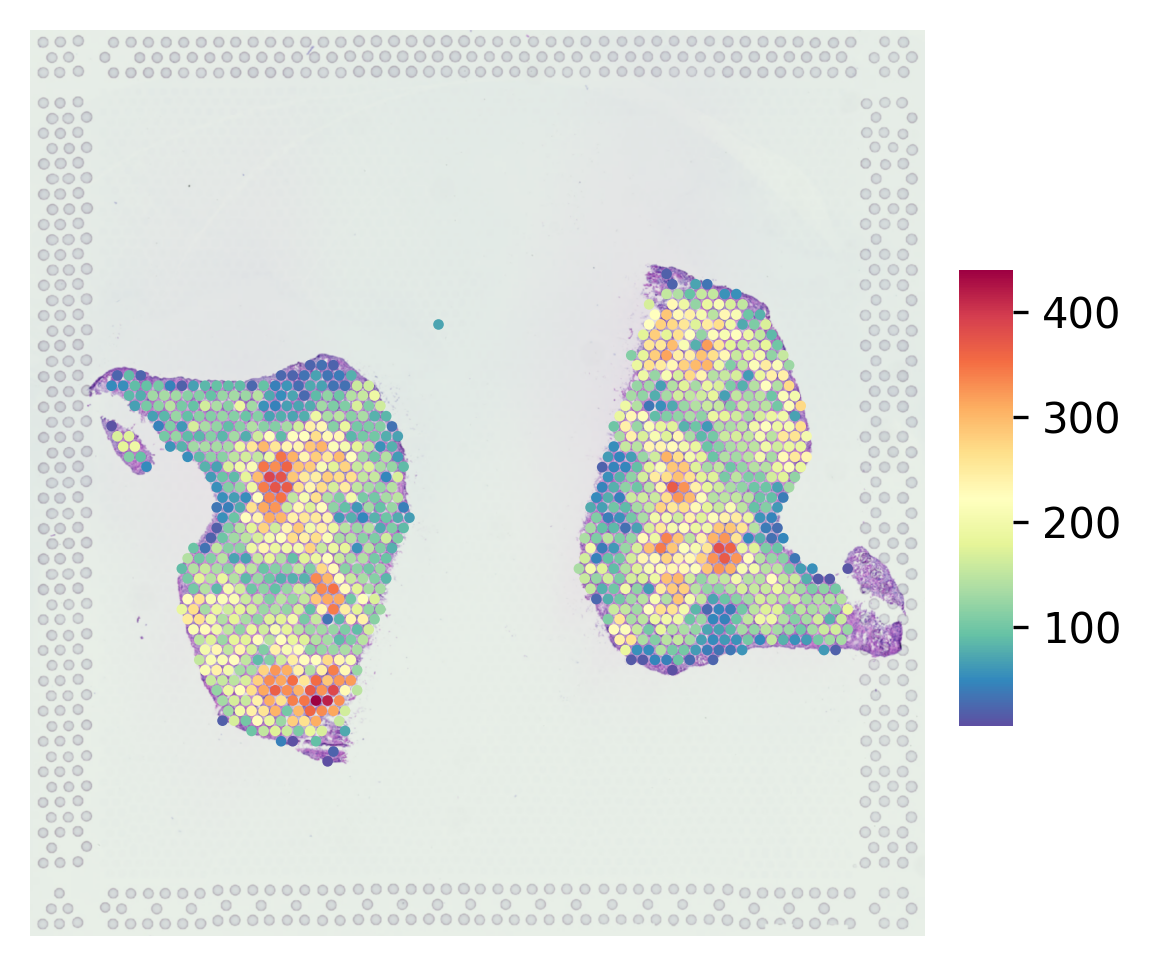

Counts for cluster (cell type) diversity stored into adata.uns['cci_het']
Results of spatial interaction analysis has been written to adata.uns['merged']


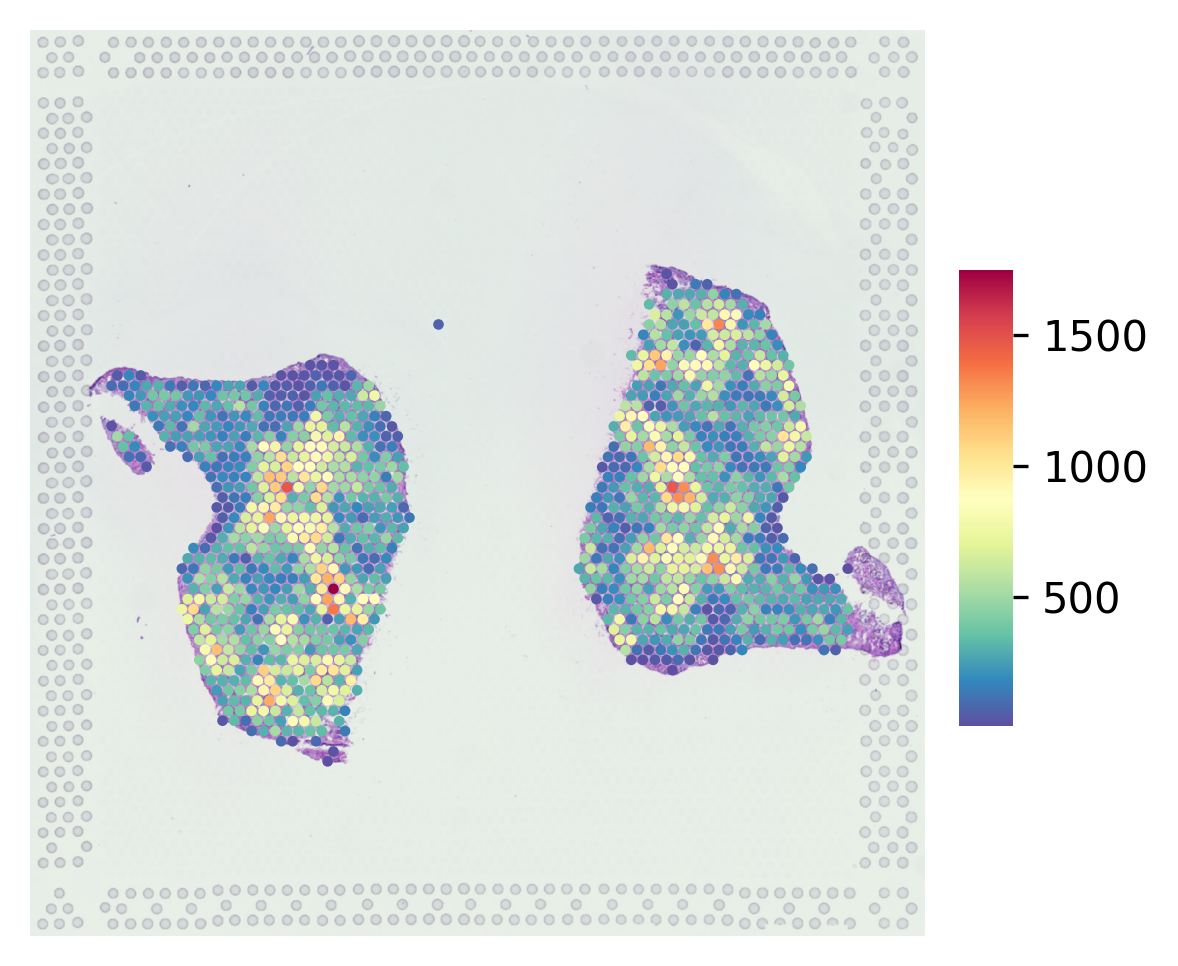

/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


#cells MT filtered: 70
#cells left: 1343


Trying to set attribute `.var` of view, copying.


Normalization step is finished in adata.X
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|██████████ [ time left: 00:00 ]


The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by morphology is added to adata.obsm['raw_morphology']
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
UMAP is done! Generated in adata.obsm['X_umap'] nad adata.uns['umap']
Applying Kmeans clustering ...


/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:932: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "
/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]
cpdb results added to adata.uns['cpdb']
Added ligand receptor pairs to adata.uns['lr'].
Altogether 942 valid L-R pairs
L-R interactions with neighbours are counted and stored into adata\.uns['cci_lr']


/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/stlearn/plotting/cci_plot.py:89: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(plot, cax=fig.add_axes(


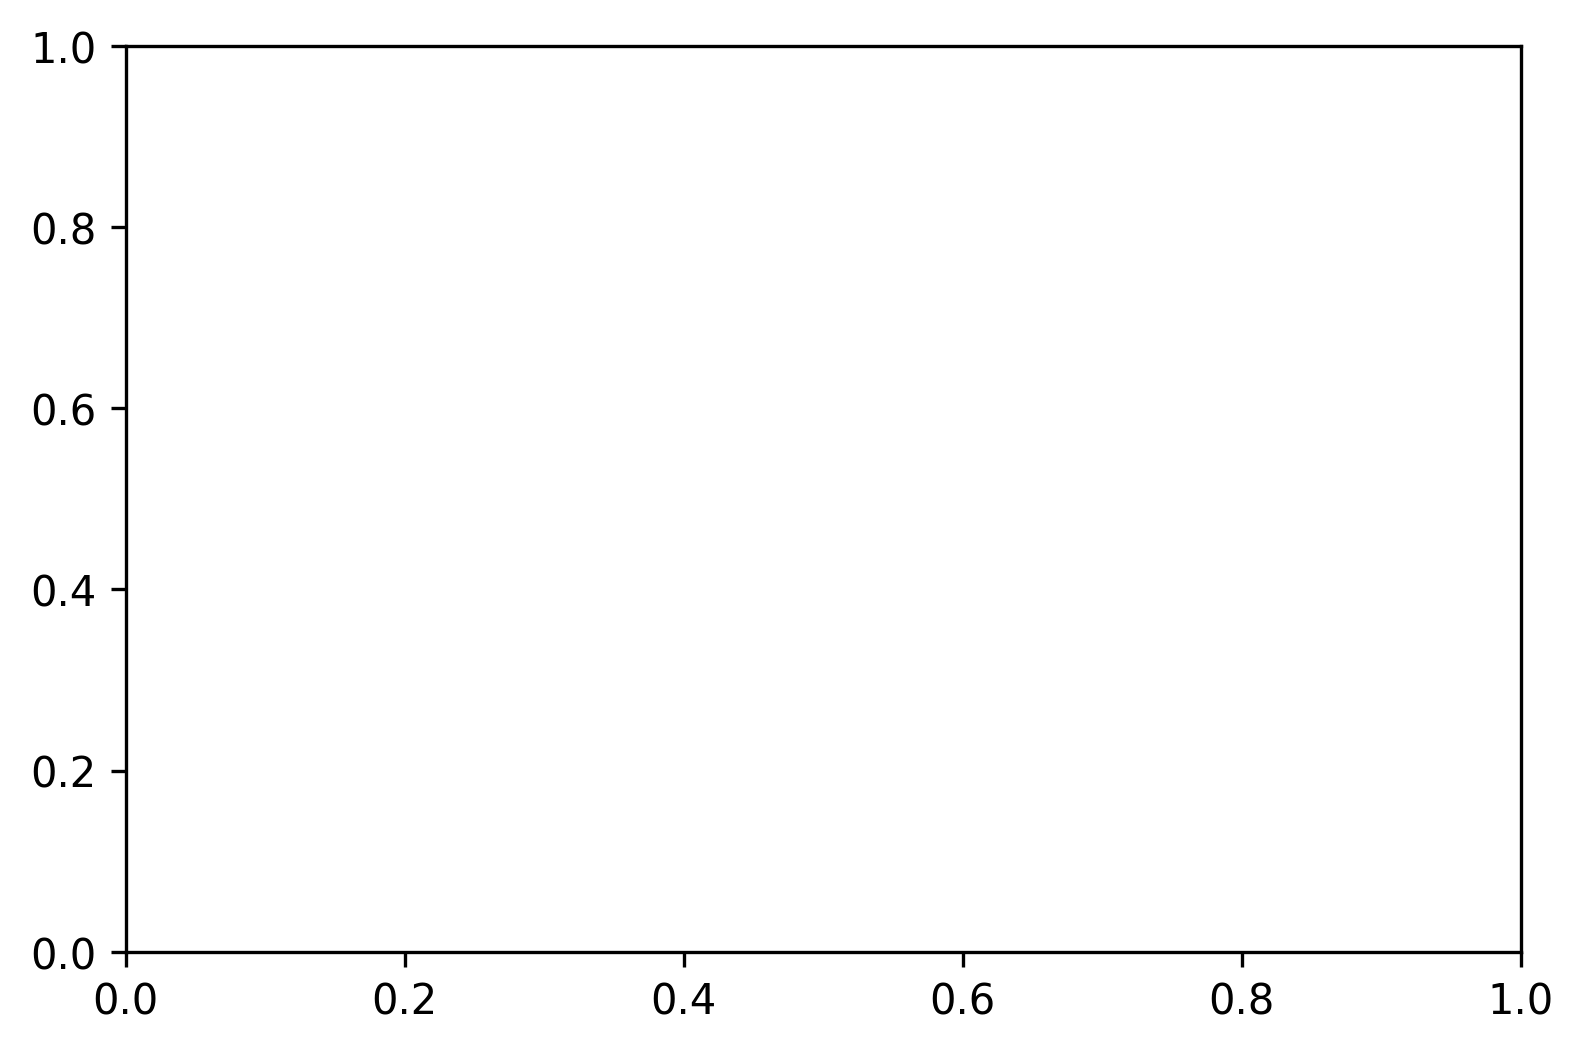

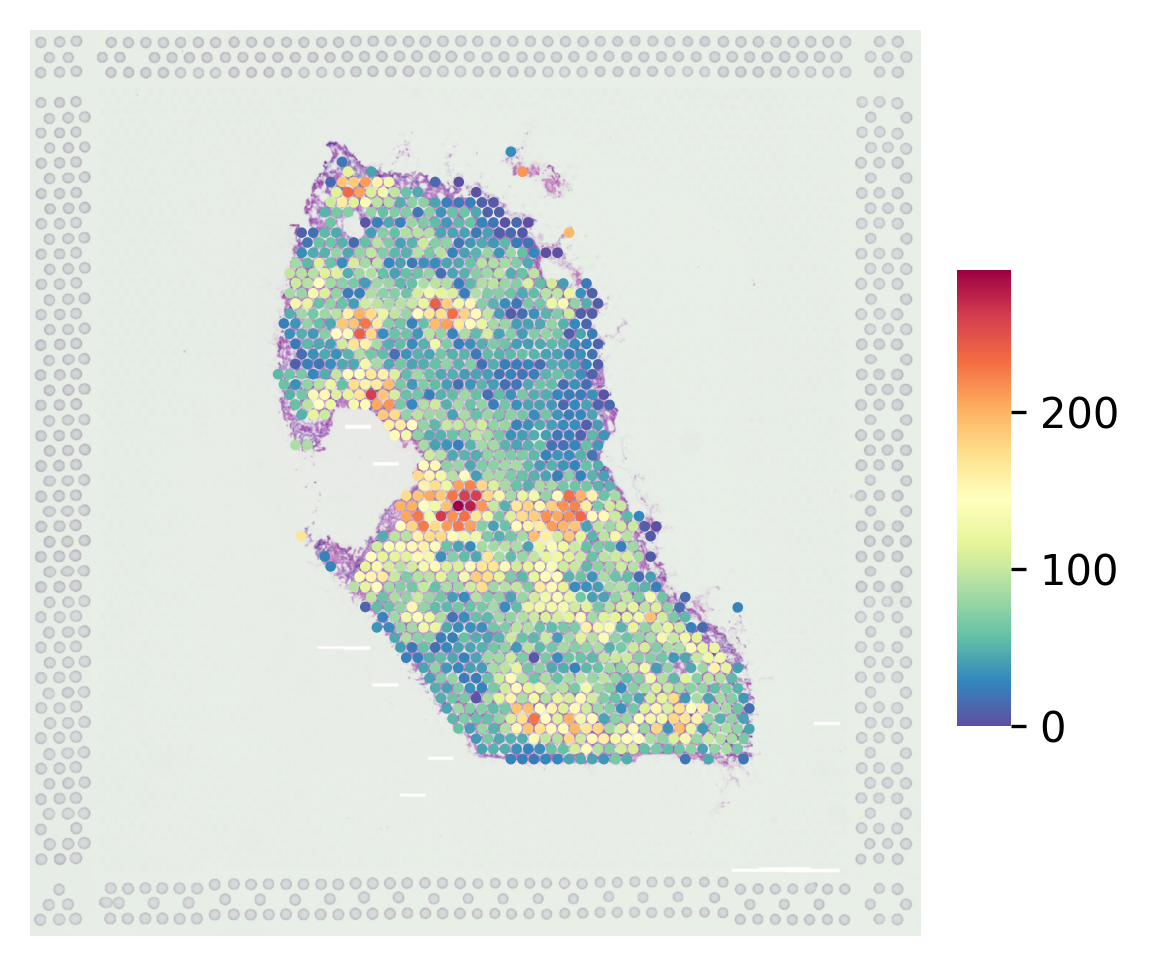

Counts for cluster (cell type) diversity stored into adata.uns['cci_het']
Results of spatial interaction analysis has been written to adata.uns['merged']


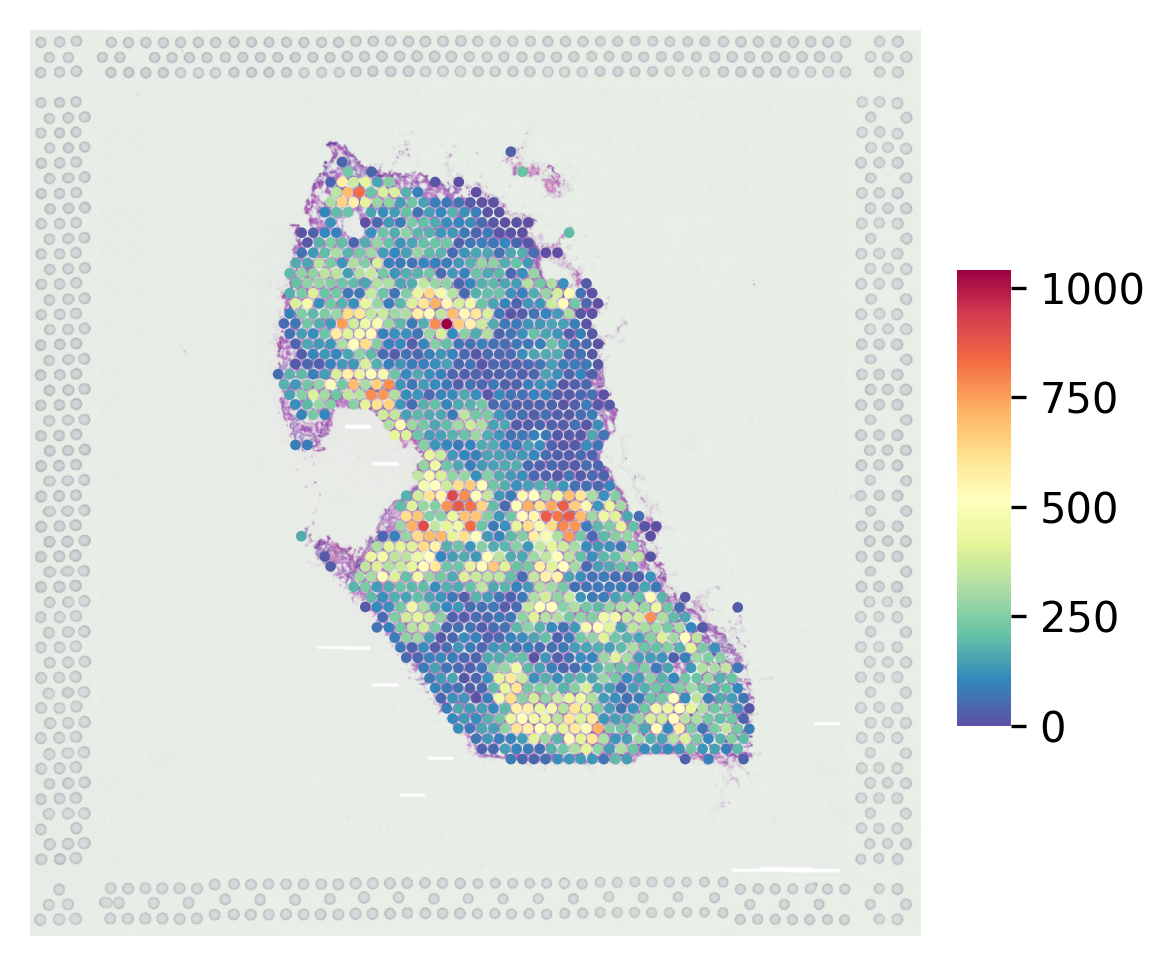

/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


#cells MT filtered: 36
#cells left: 1373


Trying to set attribute `.var` of view, copying.


Normalization step is finished in adata.X
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|██████████ [ time left: 00:00 ]


The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by morphology is added to adata.obsm['raw_morphology']
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
UMAP is done! Generated in adata.obsm['X_umap'] nad adata.uns['umap']
Applying Kmeans clustering ...


/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:932: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "
/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]
cpdb results added to adata.uns['cpdb']
Added ligand receptor pairs to adata.uns['lr'].
Altogether 1088 valid L-R pairs
L-R interactions with neighbours are counted and stored into adata\.uns['cci_lr']


/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/stlearn/plotting/cci_plot.py:89: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(plot, cax=fig.add_axes(


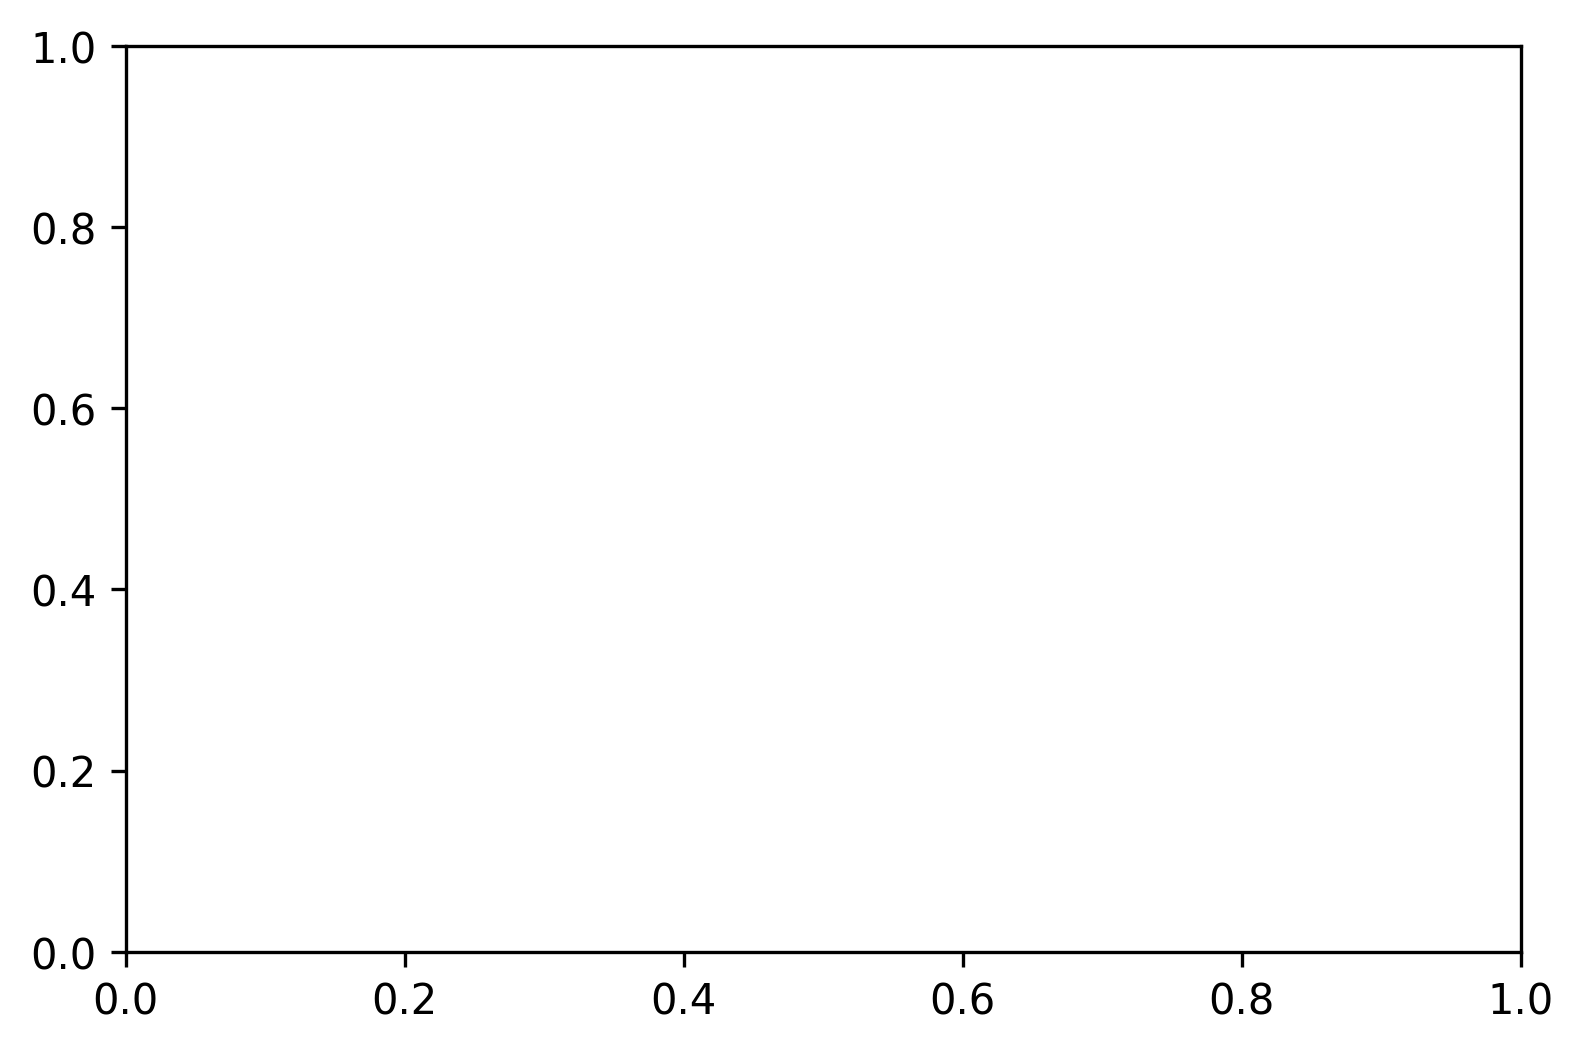

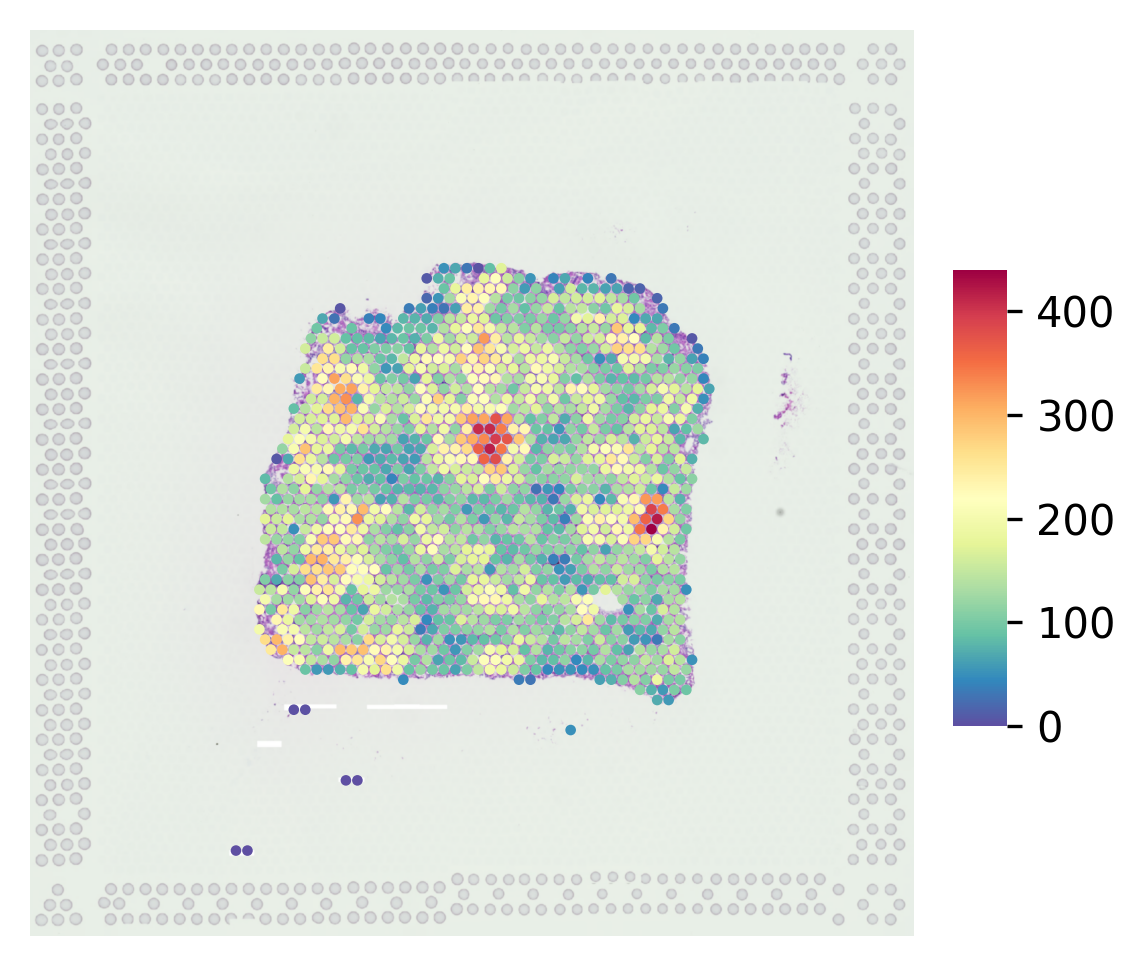

Counts for cluster (cell type) diversity stored into adata.uns['cci_het']
Results of spatial interaction analysis has been written to adata.uns['merged']


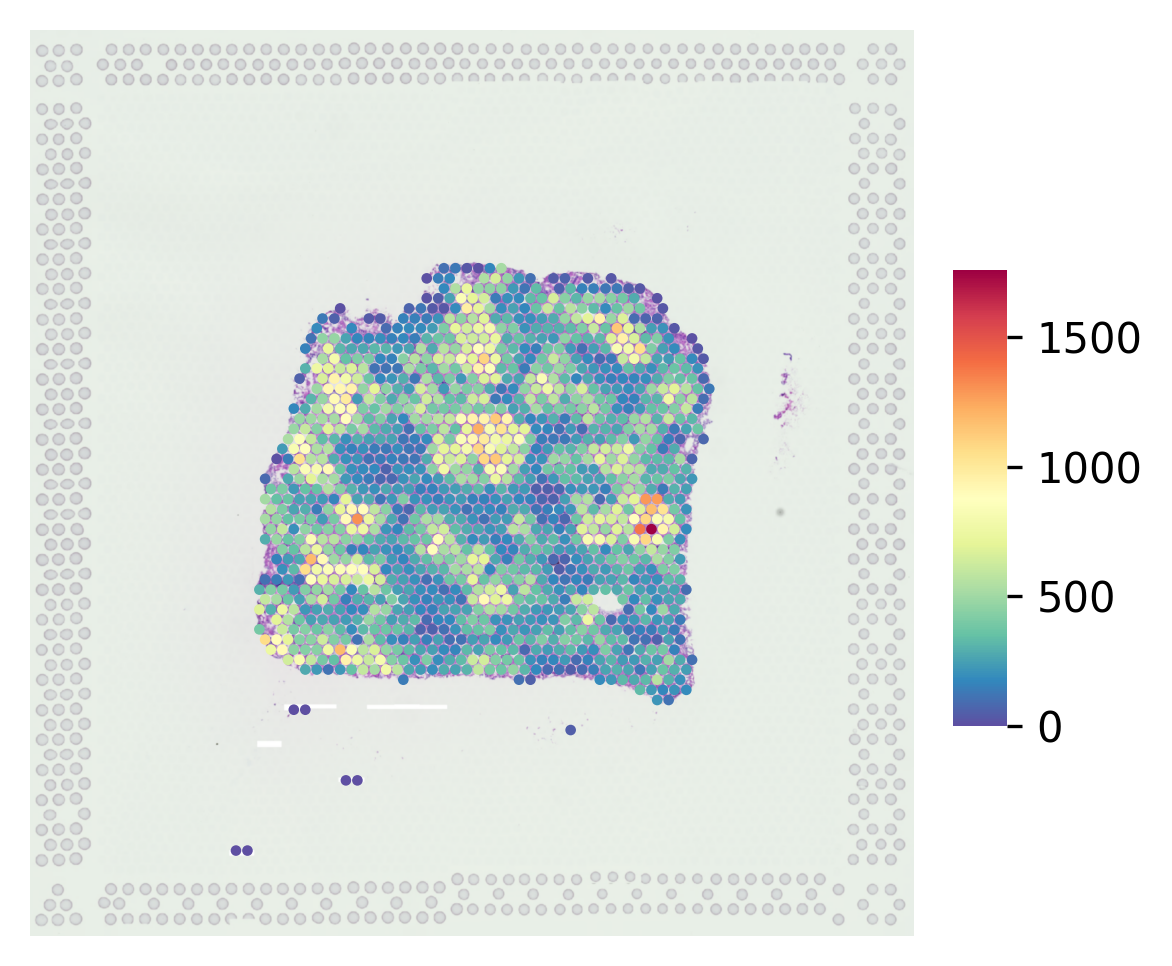

/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.var` of view, copying.
/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


#cells MT filtered: 319
#cells left: 1229


Trying to set attribute `.var` of view, copying.


Normalization step is finished in adata.X
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|██████████ [ time left: 00:00 ]


The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by morphology is added to adata.obsm['raw_morphology']
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
UMAP is done! Generated in adata.obsm['X_umap'] nad adata.uns['umap']
Applying Kmeans clustering ...


/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:932: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "
/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]
cpdb results added to adata.uns['cpdb']
Added ligand receptor pairs to adata.uns['lr'].
Altogether 1346 valid L-R pairs
L-R interactions with neighbours are counted and stored into adata\.uns['cci_lr']


/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/stlearn/plotting/cci_plot.py:89: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(plot, cax=fig.add_axes(


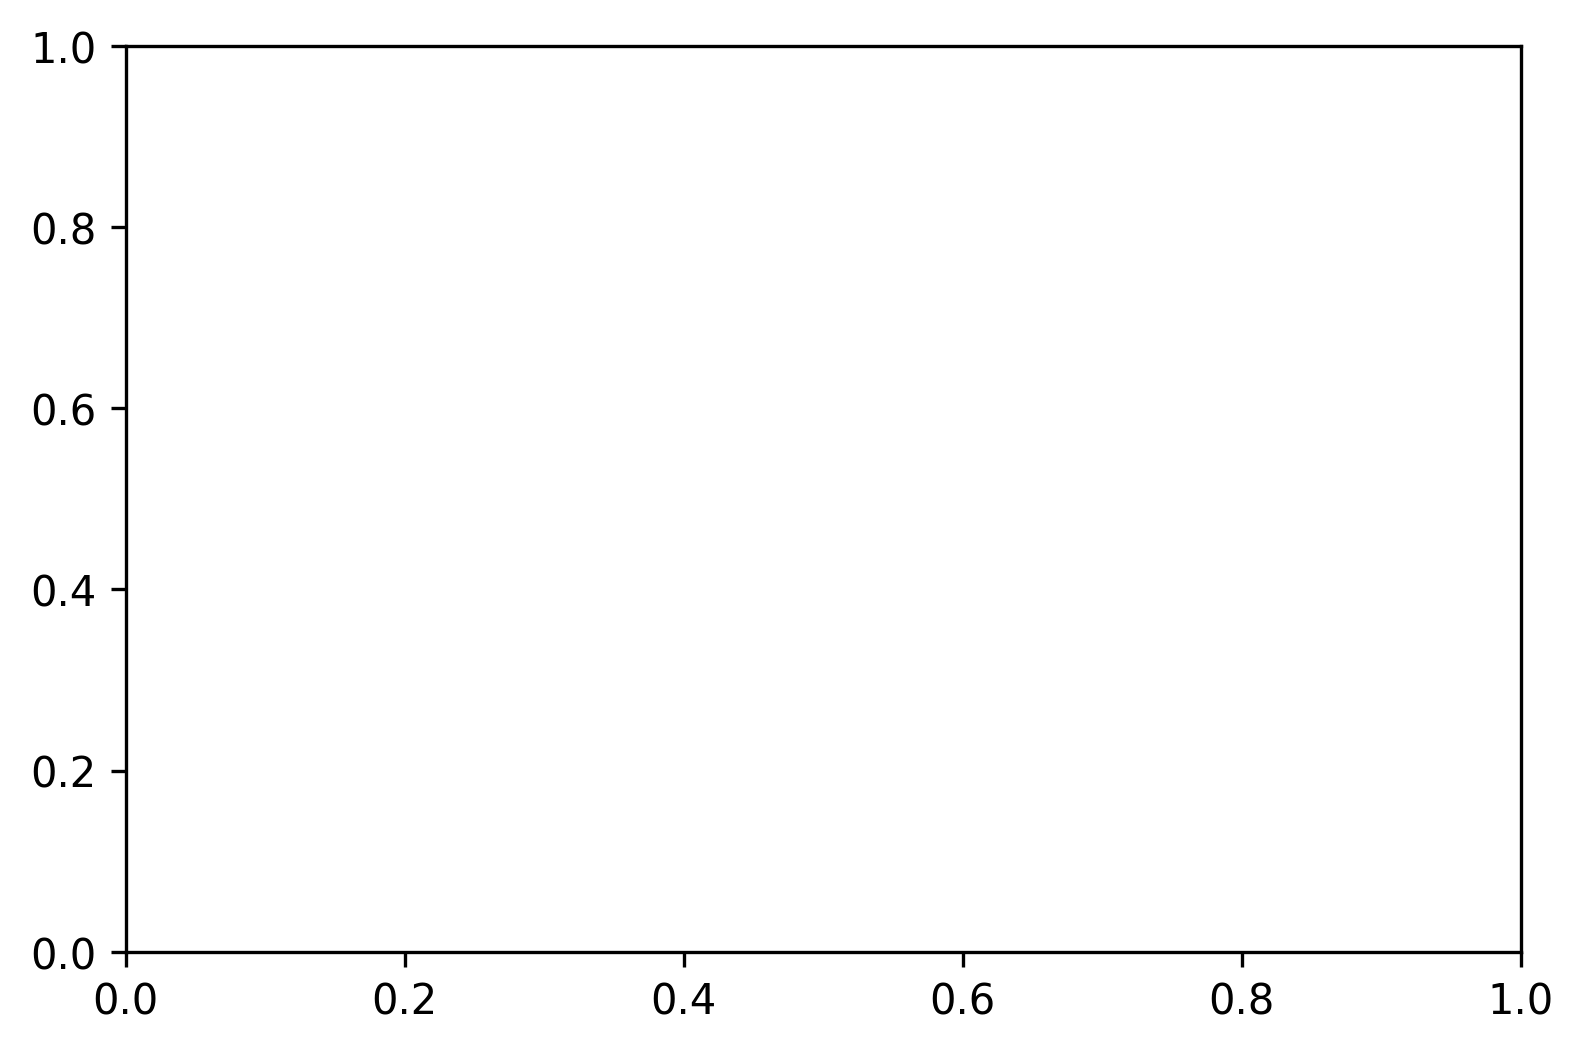

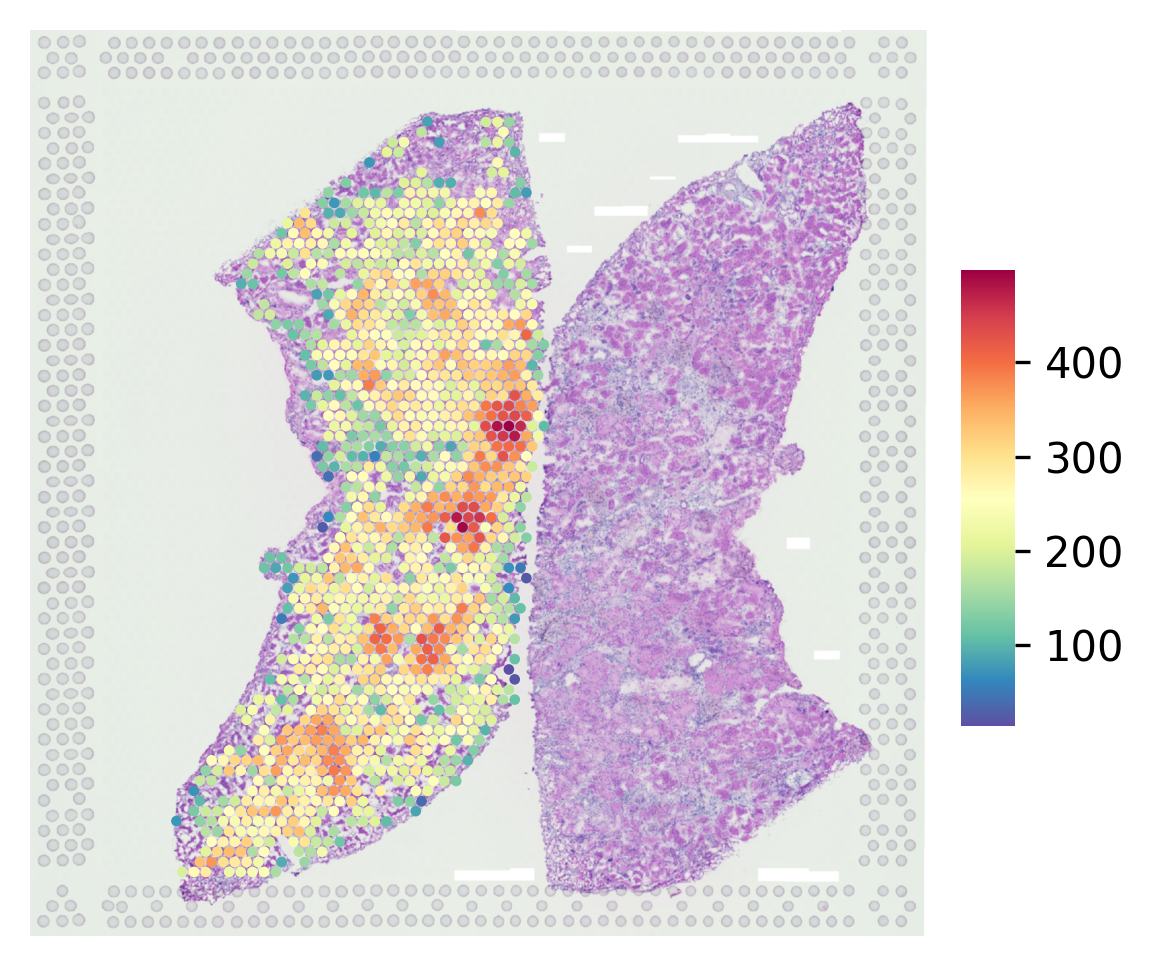

Counts for cluster (cell type) diversity stored into adata.uns['cci_het']
Results of spatial interaction analysis has been written to adata.uns['merged']


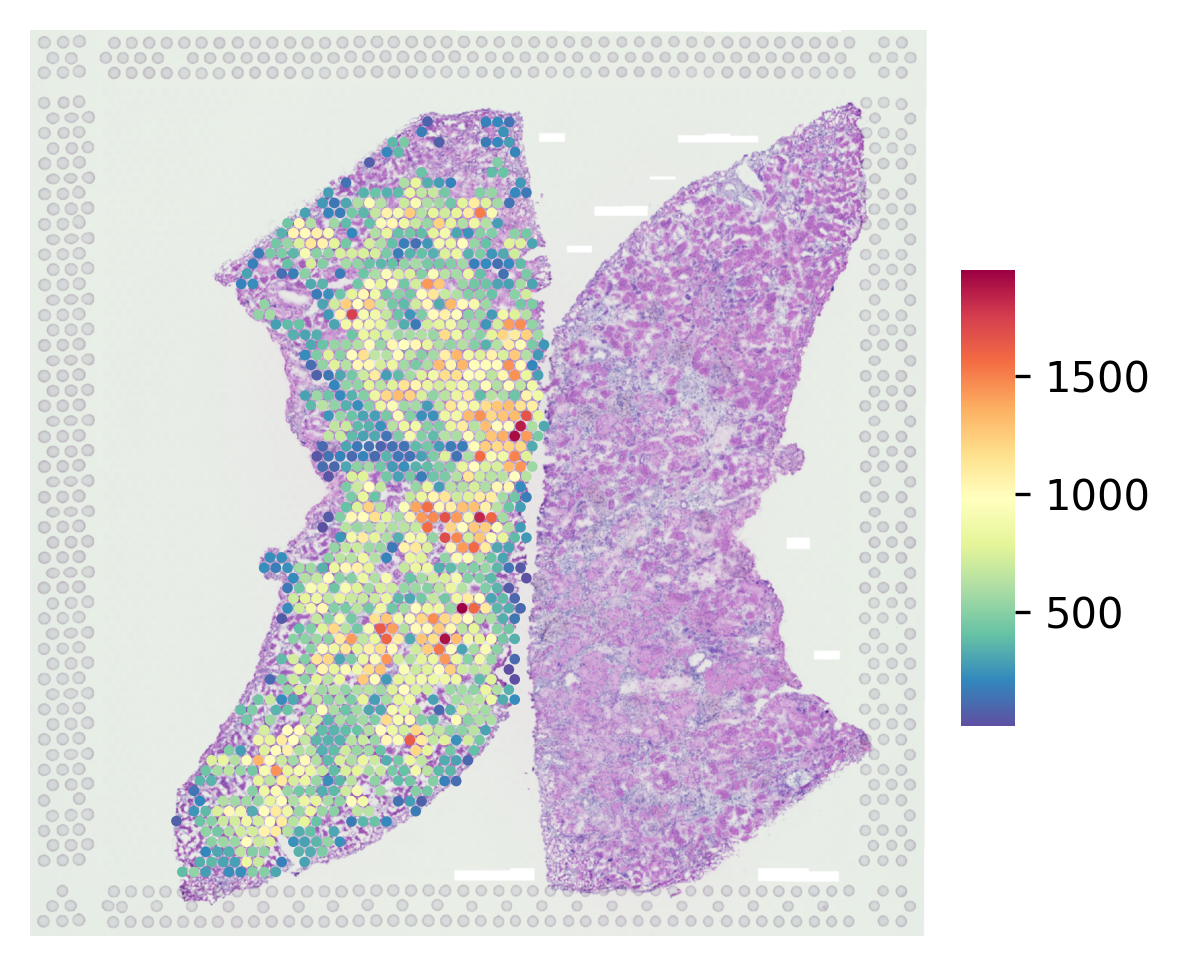

/home/uqxtan9/90days/.conda/envs/stlearncci/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [15]:
for adata in [
    A1,
    B1,
    C1,
    D1
]:
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
    n_cell = adata.n_obs
    adata = adata[adata.obs["pct_counts_mt"] < 50]
    print(f"#cells MT filtered: {n_cell - adata.n_obs}")
    print(f"#cells left: {adata.n_obs}")
    st.pp.filter_genes(adata,min_cells=1)
    st.pp.normalize_total(adata)
    st.pp.log1p(adata)
    # st.pp.scale(adata)
    TILE_PATH = BASE_PATH / (list(adata.uns["spatial"].keys())[0]+"_tile") 
    TILE_PATH.mkdir(parents=True, exist_ok=True)
    st.pp.tiling(adata, TILE_PATH, crop_size=40)
    st.pp.extract_feature(adata)
    adata = st.spatial.morphology.adjust(adata,use_data="raw",radius=50,method="mean",copy=True)
    adata.X = adata.obsm["raw_morphology"]
    st.em.run_pca(adata,n_comps=50)
    st.pp.neighbors(adata,n_neighbors=10,use_rep='X_pca')
    st.em.run_umap(adata)
    adata.obsm["normalized_total"] = adata.to_df()
    # K-means clustering on stMLE normalised PCA
    st.tl.clustering.kmeans(adata,n_clusters=5, use_data="X_pca", key_added="X_pca_kmeans")
    
    OUT_PATH = BASE_PATH / "cci_plot" / list(adata.uns["spatial"].keys())[0]
    OUT_PATH.mkdir(parents=True, exist_ok=True)
    try:
#         for single_lr in lr_list:
#             adata.uns["lr"] = [single_lr]
#             st.tl.cci.base.lr(adata=adata, use_data='raw_morphology', distance=0)
#             st.pl.het_plot(adata, use_het='cci_lr', dpi=300, name="cci_het_"+single_lr, output=str(OUT_PATH))
#             st.tl.cci.het.count(adata,  use_clustering='X_pca_kmeans')
#             st.tl.cci.merge(adata, use_lr='cci_lr', use_het="cci_het")
#             st.pl.het_plot(adata, use_het='merged', dpi=300, name="cci_het_merged"+single_lr, output=str(OUT_PATH))
#             st.tl.cci.permutation(adata, n_pairs=200, distance=0)
#             # plot the -log10(pvalue) from permutation test on each spot
#             st.pl.het_plot(adata, use_het='merged_pvalues', dpi=300, name="permutation"+single_lr, output=str(OUT_PATH))
#             st.pl.het_plot(adata, use_het='merged_sign', dpi=300, name="final"+single_lr, output=str(OUT_PATH))

        adata.uns["lr"] = lr_list
#         st.tl.cci.base.lr(adata=adata, use_data='raw_morphology', distance=0)
#         st.pl.het_plot(adata, use_het='cci_lr', dpi=300, name="cci_het_ALL", output=str(OUT_PATH))
#         st.tl.cci.het.count(adata,  use_clustering='X_pca_kmeans')
#         st.tl.cci.merge(adata, use_lr='cci_lr', use_het="cci_het")
#         st.pl.het_plot(adata, use_het='merged', dpi=300, name="cci_het_ALL_merged", output=str(OUT_PATH))
        
        st.add.lr(adata=adata, cpdb_filepath =str(BASE_PATH / "means.txt"))
        # cpdb
        st.tl.cci.base.lr(adata=adata, use_data='raw_morphology', distance=0)
        st.pl.het_plot(adata, use_het='cci_lr', dpi=300, name="cci_het_cpdb", output=str(OUT_PATH))
        st.tl.cci.het.count(adata,  use_clustering='X_pca_kmeans')
        st.tl.cci.merge(adata, use_lr='cci_lr', use_het="cci_het")
        st.pl.het_plot(adata, use_het='merged', dpi=300, name="cci_het_cpdb_merged", output=str(OUT_PATH))
        adata = adata[adata.obs["mask_annotation"] == "glomerulus"].copy()
        st.pl.het_plot(adata, use_het='cci_lr', dpi=300, name="cci_het_cpdb_glomerulus", output=str(OUT_PATH))
        st.pl.het_plot(adata, use_het='merged', dpi=300, name="cci_het_cpdb_glomerulus_merged", output=str(OUT_PATH))
    except:
        continue
              

In [30]:
A1

AnnData object with n_obs × n_vars = 1242 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sum_counts', 'imagecol', 'imagerow', 'sex', 'sp', 'mask_annotation', 'mask_annotation_code', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'mask_image', 'mask_annotation', 'lr'
    obsm: 'spatial'

In [103]:
A1 = A1[A1.obs["mask_annotation"] == "glomerulus"].copy()

In [104]:
A1

AnnData object with n_obs × n_vars = 35 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sum_counts', 'imagecol', 'imagerow', 'sex', 'sp', 'mask_annotation', 'mask_annotation_code'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'mask_image', 'mask_annotation'
    obsm: 'spatial'

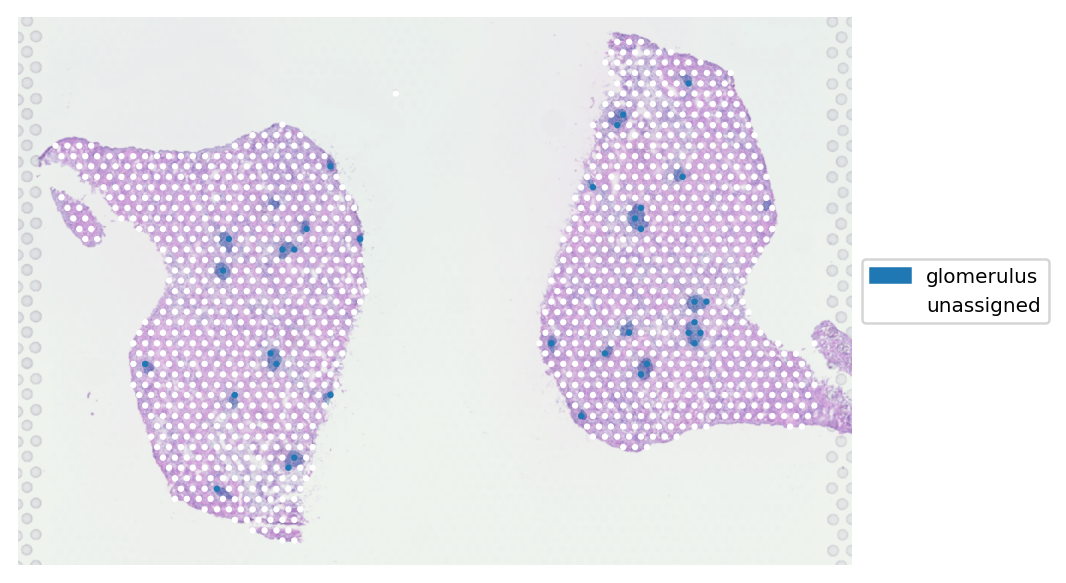

In [102]:
plot_mask(A1, mask_alpha=0.3)